# 数据挖掘实践任务

<b>任务描述</b>

- 使用网格搜索法对5个模型（逻辑回归、SVM、决策树、随机森林、XGBoost）进行调优（调参时采用五折交叉验证的方式），并进行模型评估

In [1]:
# 获取Task2进行特征选择后的数据集
import pandas as pd
dataset = pd.read_csv('./dataset/task2_proc.csv')
features = dataset.iloc[:,:-1]
labels = dataset.iloc[:,-1]
print('feature shape:{}, label shape:{}'.format(features.shape,labels.shape))

feature shape:(4455, 49), label shape:(4455,)


In [2]:
# 数据拆分
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

random_state = 2018
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size = 0.3,random_state=random_state)

# 对训练数据集进行标准化处理
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

In [3]:
# 导入库
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,cross_val_predict
from scipy.stats import uniform
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [4]:
model_score_train = []   
decision_score_train = [] 
model_score_test = []   
decision_score_test = []

def proc_score(y_pred,y_pred_scores,y_test,train=True):  
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    roc_auc = roc_auc_score(y_test,y_pred_scores)

    if train:
        decision_score_train.append(y_pred_scores)
        model_score_train.append([accuracy,precision,recall,f1,roc_auc])
        text = 'Train'
    else:
        decision_score_test.append(y_pred_scores)
        model_score_test.append([accuracy,precision,recall,f1,roc_auc])
        text = 'Test'
    print('{} confusion matrix:\n{}'.format(text,confusion_matrix(y_test,y_pred)))
    print('{}: accuracy:{:.3f},precision:{:.3f},recall:{:.3f},f1:{:.3f},roc_auc:{:.3f}'.format(text,accuracy,precision,recall,f1,roc_auc))

# 逻辑回归

In [5]:
param_distributions = {'C':uniform(0,10)}
rs_clf = RandomizedSearchCV(LogisticRegression(solver='lbfgs',class_weight='balanced'), param_distributions=param_distributions, cv = 5,n_iter=100,
                           random_state=random_state,verbose=2,n_jobs=-1)
rs_clf.fit(x_train_scale,y_train)
logistic = rs_clf.best_estimator_
#保存模型
with open('./model_saved/logistic.pickle','wb') as pf:
    pickle.dump(logistic,pf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.4s finished


In [6]:
with open('./model_saved/logistic.pickle','rb') as pf:
    logistic = pickle.load(pf)
    y_pred = logistic.predict(x_train_scale)
    y_pred_scores = cross_val_predict(logistic,x_train_scale,y_train,cv=5,
                                    method='decision_function')
    proc_score(y_pred,y_pred_scores,y_train,train=True)
    y_pred = logistic.predict(x_test_scale)
    y_pred_scores = cross_val_predict(logistic,x_test_scale,y_test,cv=5,
                                    method='decision_function')
    proc_score(y_pred,y_pred_scores,y_test,train=False)

Train confusion matrix:
[[1765  556]
 [ 233  564]]
Train: accuracy:0.747,precision:0.504,recall:0.708,f1:0.588,roc_auc:0.792
Test confusion matrix:
[[768 245]
 [ 99 225]]
Test: accuracy:0.743,precision:0.479,recall:0.694,f1:0.567,roc_auc:0.793


# SVM

In [7]:
param_distributions = {'C':uniform(0,10)}
rs_clf = RandomizedSearchCV(SVC(kernel='rbf',gamma='auto',class_weight='balanced'), param_distributions=param_distributions,cv=5,n_iter=50,
                              random_state=random_state,verbose=2,n_jobs=-1)
rs_clf.fit(x_train_scale, y_train)
with open('./model_saved/svc.pickle','wb') as pf:
    pickle.dump(rs_clf.best_estimator_,pf)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.3min finished


In [8]:
with open('./model_saved/svc.pickle','rb') as pf:
    svc = pickle.load(pf) 
    y_pred = svc.predict(x_train_scale)
    y_pred_scores = cross_val_predict(svc,x_train_scale,y_train,cv=3,
                                    method='decision_function')
    proc_score(y_pred,y_pred_scores,y_train,train=True)

    y_pred = svc.predict(x_test_scale)
    y_pred_scores = cross_val_predict(svc,x_test_scale,y_test,cv=5,
                                    method='decision_function')
    proc_score(y_pred,y_pred_scores,y_test,train=False)

Train confusion matrix:
[[1840  481]
 [ 186  611]]
Train: accuracy:0.786,precision:0.560,recall:0.767,f1:0.647,roc_auc:0.780
Test confusion matrix:
[[788 225]
 [119 205]]
Test: accuracy:0.743,precision:0.477,recall:0.633,f1:0.544,roc_auc:0.776


# 决策树

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':np.linspace(2,32,31,dtype=np.int32),
             'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
             'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
             'class_weight':['balanced']}

gs_clf = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,iid=True,cv=5,verbose=2,n_jobs=-1)
gs_clf.fit(x_train_scale,y_train)
with open('./model_saved/DecisionTree.pickle','wb') as pf:
    pickle.dump(gs_clf.best_estimator_,pf)

Fitting 5 folds for each of 1550 candidates, totalling 7750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 766 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1898 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 3358 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 5138 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 7246 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7750 out of 7750 | elapsed:  1.3min finished


In [10]:
with open('./model_saved/DecisionTree.pickle','rb') as pf:
    dt_clf = pickle.load(pf)
    print(dt_clf)
    y_pred = dt_clf.predict(x_train_scale)
    y_pred_scores = cross_val_predict(dt_clf,x_train_scale,y_train,cv=5,
                                    method='predict_proba')
    proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

    y_pred = dt_clf.predict(x_test_scale)
    y_pred_scores = cross_val_predict(dt_clf,x_test_scale,y_test,cv=5,
                                    method='predict_proba')
    proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Train confusion matrix:
[[1657  664]
 [ 260  537]]
Train: accuracy:0.704,precision:0.447,recall:0.674,f1:0.538,roc_auc:0.756
Test confusion matrix:
[[743 270]
 [115 209]]
Test: accuracy:0.712,precision:0.436,recall:0.645,f1:0.521,roc_auc:0.745


# 随机森林

In [11]:
# param_grid = {'max_depth':np.linspace(2,64,31,dtype=np.int32),
#              'min_samples_split':np.linspace(0.1, 1.0, 10),
#              'min_samples_leaf':np.linspace(0.1, 0.5, 5)}
param_grid = {'max_depth':np.linspace(2,64,31,dtype=np.int32)}
gd_clf = GridSearchCV(RandomForestClassifier(n_estimators=100,criterion='gini'),
                      param_grid=param_grid,cv=5,verbose=2,n_jobs=-1)
gd_clf.fit(x_train_scale,y_train)
print(gd_clf.best_estimator_)
with open('./model_saved/RandomForest.pickle','wb') as pf:
    pickle.dump(gd_clf.best_estimator_,pf)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 155 out of 155 | elapsed:   37.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [12]:
with open('./model_saved/RandomForest.pickle','rb') as pf:
    rf_clf = pickle.load(pf)
    y_pred = rf_clf.predict(x_train_scale)
    y_pred_scores = cross_val_predict(rf_clf,x_train_scale,y_train,cv=5,
                                    method='predict_proba')
    proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

    y_pred = rf_clf.predict(x_test_scale)
    y_pred_scores = cross_val_predict(rf_clf,x_test_scale,y_test,cv=5,
                                    method='predict_proba')
    proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

Train confusion matrix:
[[2321    0]
 [   1  796]]
Train: accuracy:1.000,precision:1.000,recall:0.999,f1:0.999,roc_auc:0.781
Test confusion matrix:
[[967  46]
 [225  99]]
Test: accuracy:0.797,precision:0.683,recall:0.306,f1:0.422,roc_auc:0.773


# xgboost

In [13]:
from xgboost import XGBClassifier
xgbst = XGBClassifier()
xgbst.fit(x_train_scale,y_train)
with open('./model_saved/xgboost.pickle','wb') as pf:
    pickle.dump(xgbst,pf)

In [14]:
with open('./model_saved/xgboost.pickle','rb') as pf:
    xgbst = pickle.load(pf)
    y_pred = xgbst.predict(x_train_scale)
    y_pred_scores = cross_val_predict(xgbst,x_train_scale,y_train,cv=5,
                                    method='predict_proba')
    proc_score(y_pred,y_pred_scores[:,1],y_train,train=True)

    y_pred = xgbst.predict(x_test_scale)
    y_pred_scores = cross_val_predict(xgbst,x_test_scale,y_test,cv=5,
                                    method='predict_proba')
    proc_score(y_pred,y_pred_scores[:,1],y_test,train=False)

Train confusion matrix:
[[2236   85]
 [ 394  403]]
Train: accuracy:0.846,precision:0.826,recall:0.506,f1:0.627,roc_auc:0.787
Test confusion matrix:
[[965  48]
 [226  98]]
Test: accuracy:0.795,precision:0.671,recall:0.302,f1:0.417,roc_auc:0.781


# 对各模型分数进行比较

In [15]:
# 绘制ROC取下对比图
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')

In [16]:
model_name = ['Logistic','SVM','DecisionTree','RandomForest','xgboost']
columns = ['accuracy','precision','recall','f1','roc_auc']
ttype = ['train','test']
pd_list = []
for train,test in zip(model_score_train,model_score_test):
    pd_list.append(pd.DataFrame([train,test],index=ttype,columns=columns))
    
pd.concat(pd_list,axis=0,keys=model_name)

accuracy  precision    recall        f1   roc_auc
Logistic     train  0.746953   0.503571  0.707654  0.588419  0.792032
             test   0.742708   0.478723  0.694444  0.566751  0.792704
SVM          train  0.786081   0.559524  0.766625  0.646903  0.780417
             test   0.742708   0.476744  0.632716  0.543767  0.775953
DecisionTree train  0.703656   0.447127  0.673777  0.537538  0.756004
             test   0.712042   0.436326  0.645062  0.520548  0.744834
RandomForest train  0.999679   1.000000  0.998745  0.999372  0.781430
             test   0.797307   0.682759  0.305556  0.422175  0.773061
xgboost      train  0.846376   0.825820  0.505646  0.627237  0.787055
             test   0.795064   0.671233  0.302469  0.417021  0.781169

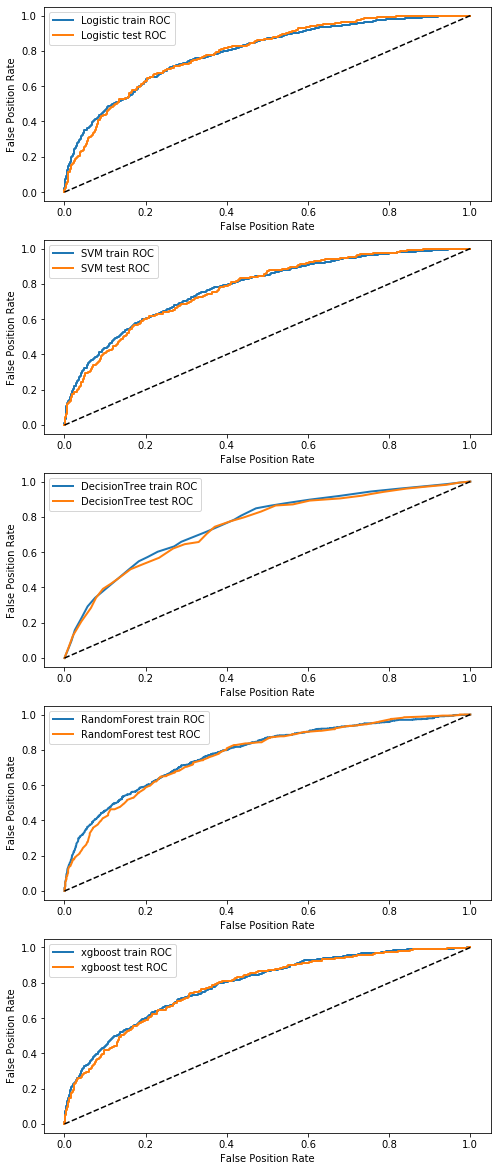

In [17]:
fig = plt.figure(figsize=(8,25))
for i,label in enumerate(model_name):
    train_fpr,train_tpr,train_threshold = roc_curve(y_train,decision_score_train[i])
    test_fpr,test_tpr,test_threshold = roc_curve(y_test,decision_score_test[i])
    ax = fig.add_subplot(int('61'+str(i+1)))
    ax.plot(train_fpr,train_tpr,linewidth=2,label=label+' train ROC')
    ax.plot(test_fpr,test_tpr,linewidth=2,label=label+' test ROC')
    ax.plot([0,1],[0,1],'k--')
    ax.legend()
    plt.xlabel('False Position Rate')
    plt.ylabel('False Position Rate')
    
plt.show()

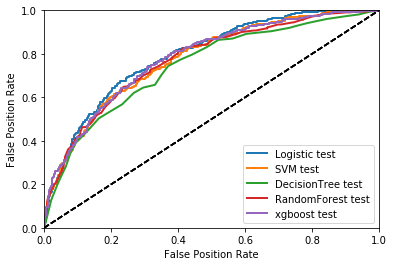

In [18]:
for score,label in zip(decision_score_test,['Logistic','SVM','DecisionTree','RandomForest','xgboost']):
    fpr,tpr,threshold = roc_curve(y_test,score)
    plot_roc_curve(fpr,tpr,label=label+' test')
plt.rcParams['figure.figsize'] = (8,5)    
plt.axis([0,1,0,1])
plt.xlabel('False Position Rate')
plt.ylabel('False Position Rate')
plt.legend()
plt.show()